In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

## 1. load data

In [2]:
import pandas as pd
df = pd.read_csv("timeseries.csv")

In [3]:
df

,Entity,Code,Year,Total deaths from stroke among both sexes
0,Afghanistan,AFG,2000,14641.85
1,Afghanistan,AFG,2001,14892.41
2,Afghanistan,AFG,2002,15578.43
3,Afghanistan,AFG,2003,16700.15
4,Afghanistan,AFG,2004,17119.86
...,...,...,...,...
4417,Zimbabwe,ZWE,2017,9190.36
4418,Zimbabwe,ZWE,2018,9485.22
4419,Zimbabwe,ZWE,2019,9394.89
4420,Zimbabwe,ZWE,2020,10292.84


## 3. Prepocessing

In [3]:
benua = [
    "World", "Asia", "Africa", "Europe", "European Union",
    "North America", "South America", "Latin America and Caribbean",
    "Oceania"
]
df = df[~df["Entity"].isin(benua)]

# pivot per negara: 1 negara = 1 baris data time-series
pivot = df.pivot_table(index="Entity", columns="Year", values="Total deaths from stroke among both sexes")

#  missing values
pivot = pivot.fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)

# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(pivot.values)

C:\Users\asus\AppData\Local\Temp\ipykernel_18844\1961580428.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot.fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)


In [6]:
X

array([[-0.09971315, -0.09810716, -0.09534397, ..., -0.07843706,
        -0.0737404 , -0.08093878],
       [-0.16223143, -0.17047942, -0.16568912, ..., -0.13269298,
        -0.12799183, -0.15135574],
       [-0.10202818, -0.10029132, -0.10034268, ..., -0.06415996,
        -0.05649864, -0.05127308],
       ...,
       [-0.12273802, -0.12151059, -0.12227273, ..., -0.1041229 ,
        -0.10112711, -0.10300223],
       [-0.17306374, -0.17025754, -0.16962456, ..., -0.16028488,
        -0.15618581, -0.15041851],
       [-0.16804227, -0.16362281, -0.16086525, ..., -0.13788849,
        -0.13398945, -0.13445064]], shape=(194, 22))

In [4]:
X_seq = X.reshape(X.shape[0], X.shape[1], 1)

X_tensor = torch.tensor(X_seq, dtype=torch.float32)

## 4. modelling

In [5]:
# Dataset
loader = DataLoader(TensorDataset(X_tensor), batch_size=16, shuffle=True)

In [6]:
# DEFINE LSTM AUTOENCODER
# tujuan : Mengubah data time-series (per negara) menjadi representasi tersembunyi (latent vector)
class LSTMAE(nn.Module):
    def __init__(self, input_dim=1, latent_dim=16):
        super().__init__()
        
        # encoder
        self.encoder = nn.LSTM(input_dim, 32, batch_first=True)
        self.hidden = nn.Linear(32, latent_dim)
        
        # decoder
        self.decoder_lstm = nn.LSTM(latent_dim, 32, batch_first=True)
        self.output_layer = nn.Linear(32, input_dim)

    def forward(self, x):
        # ENCODE
        _, (h, _) = self.encoder(x)
        z = self.hidden(h[-1])                     # latent vector
        
        # repeat latent vector across timesteps
        z_repeated = z.unsqueeze(1).repeat(1, x.size(1), 1)

        # DECODE
        dec_out, _ = self.decoder_lstm(z_repeated)
        out = self.output_layer(dec_out)
        
        return out, z


model = LSTMAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
# TRAIN LSTM AUTOENCODER
# tujuannya : melatih model deep learning agar encoder dan decoder bisa memahami pola time-series.
for epoch in range(150):
    for batch, in loader:
        output, _ = model(batch)
        loss = loss_fn(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch} Loss: {loss.item():.6f}")

# EXTRACT LATENT REPRESENTATION
# tjuannya : meng extract atau mengambil hasil dari train 
with torch.no_grad():
    _, latent = model(X_tensor)

latent_np = latent.numpy()

# CLUSTERING DENGAN KMEANS
# Tujuanya : melakukan clustering dengan cluster 3
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(latent_np)

pivot["cluster_raw"] = labels

cluster_order = (
    pivot.groupby("cluster_raw")[pivot.columns[0:-1]].mean().mean(axis=1).sort_values().index
)

mapping = {old: new for new, old in enumerate(cluster_order)}

pivot["cluster"] = pivot["cluster_raw"].map(mapping)

print(pivot[["cluster"]])


Epoch 0 Loss: 0.009656
Epoch 20 Loss: 0.000954
Epoch 20 Loss: 0.000954
Epoch 40 Loss: 0.000871
Epoch 40 Loss: 0.000871
Epoch 60 Loss: 0.004135
Epoch 60 Loss: 0.004135
Epoch 80 Loss: 0.000590
Epoch 80 Loss: 0.000590
Epoch 100 Loss: 0.000162
Epoch 100 Loss: 0.000162
Epoch 120 Loss: 0.000414
Epoch 120 Loss: 0.000414
Epoch 140 Loss: 0.001415
Epoch 140 Loss: 0.001415
Year         cluster
Entity              
Afghanistan        0
Albania            0
Algeria            0
Andorra            0
Angola             0
...              ...
Venezuela          0
Vietnam            1
Yemen              0
Zambia             0
Zimbabwe           0

[194 rows x 1 columns]
Year         cluster
Entity              
Afghanistan        0
Albania            0
Algeria            0
Andorra            0
Angola             0
...              ...
Venezuela          0
Vietnam            1
Yemen              0
Zambia             0
Zimbabwe           0

[194 rows x 1 columns]


In [7]:
jumlah_cluster = pivot['cluster'].value_counts()

print(jumlah_cluster)

cluster
0    184
1      9
2      1
Name: count, dtype: int64


In [8]:
pivot.to_csv("clustering_lstm.csv", index=True)

In [9]:
from sklearn.metrics import silhouette_score

score = silhouette_score(latent_np, labels)
print("Silhouette Score:", score)


Silhouette Score: 0.8886036276817322


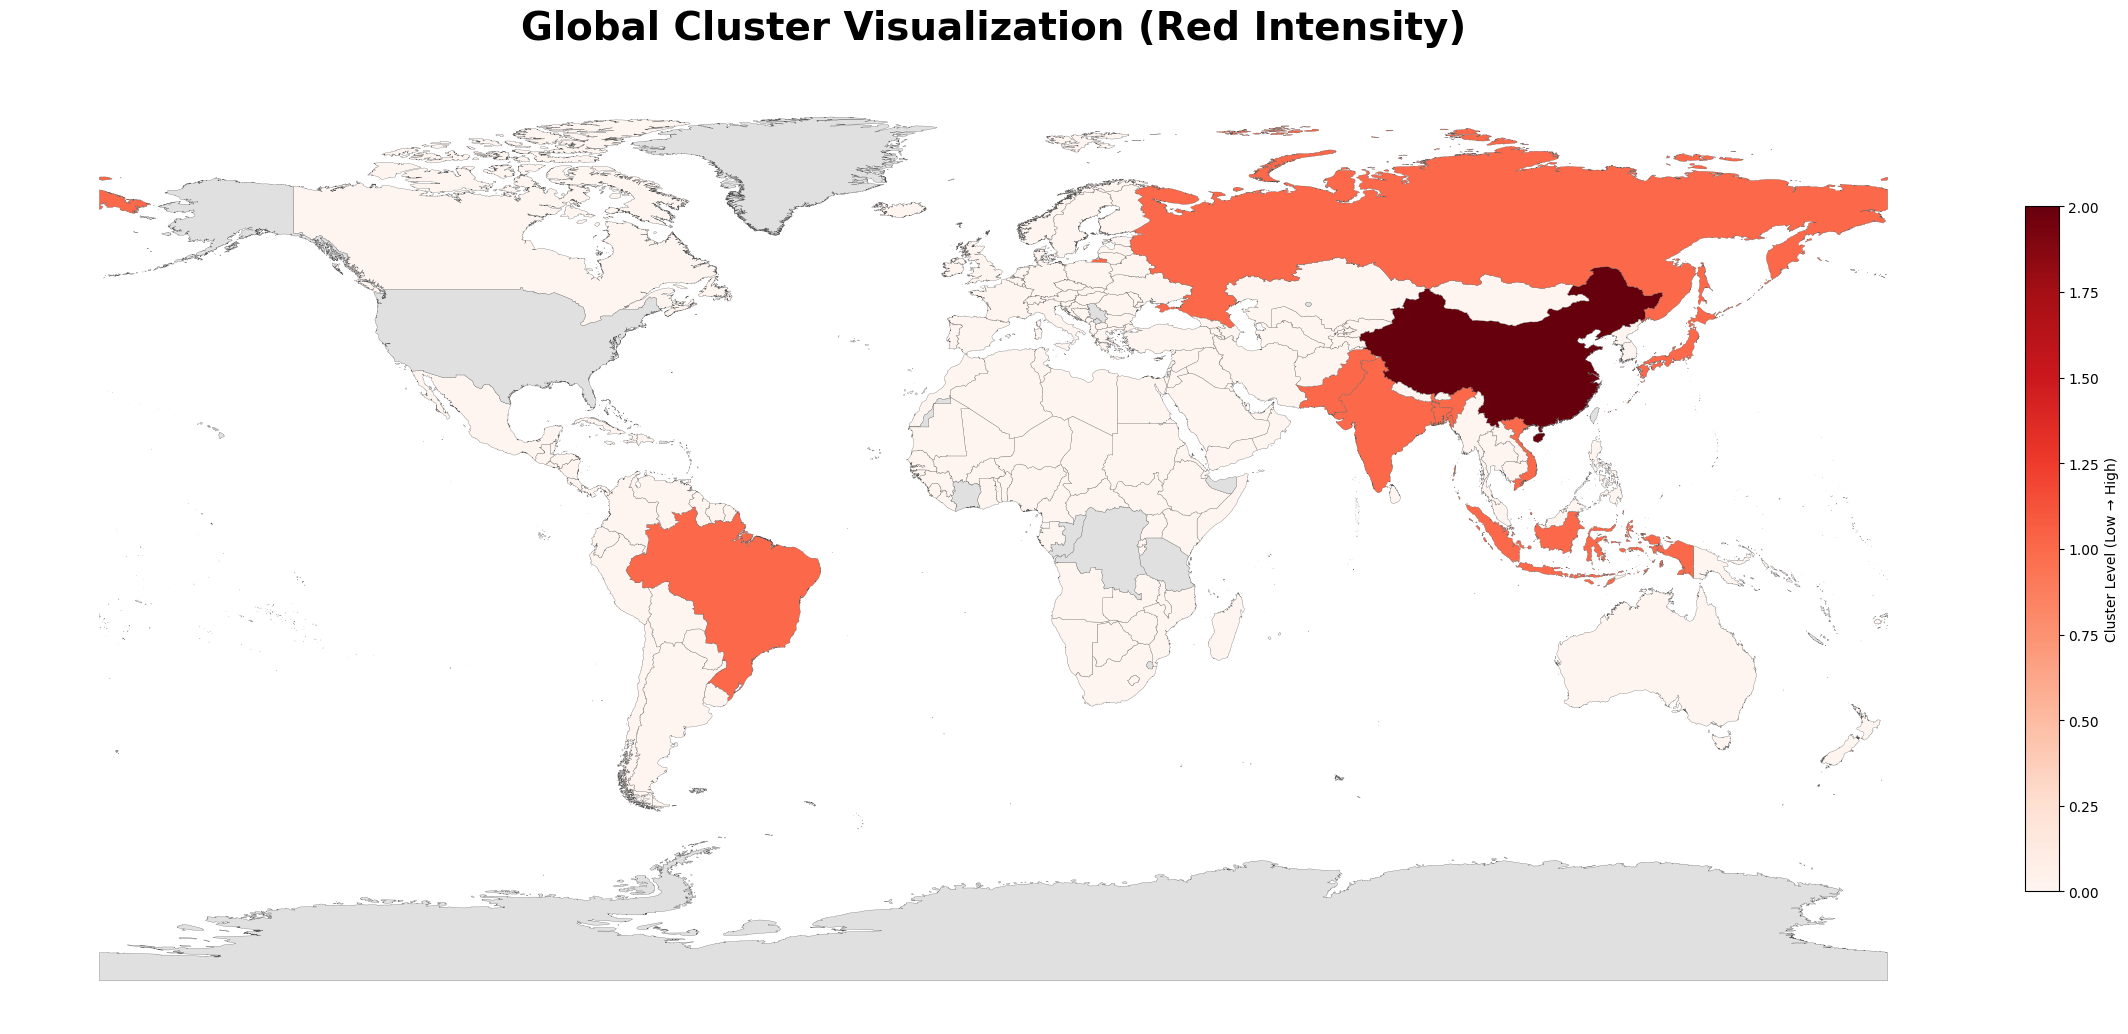

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# ============================================
# DATA CLUSTER
# ============================================
cluster_df = pivot[["cluster"]].reset_index()
cluster_df.columns = ["Entity", "cluster"]

# ============================================
# WORLD MAP
# ============================================
url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
world = gpd.read_file(url)

world = world.rename(columns={"name": "country"})

# MERGE
world_cluster = world.merge(cluster_df, how="left", left_on="country", right_on="Entity")

# ============================================
# PLOT RAPI
# ============================================
fig, ax = plt.subplots(1, 1, figsize=(24, 14))

world_cluster.plot(
    ax=ax,
    column="cluster",
    cmap="Reds",
    linewidth=0.2,
    edgecolor="#555555",        # abu-abu halus
    missing_kwds={"color": "#e0e0e0"},
    legend=True,
    legend_kwds={
        "label": "Cluster Level (Low → High)",
        "shrink": 0.5,          # legend tidak kebesaran
        "pad": 0.02
    }
)

# Hilangkan frame, axis, dan whiteborder
ax.set_axis_off()
fig.patch.set_facecolor("white")

# Judul rapi
plt.title(
    "Global Cluster Visualization (Red Intensity)",
    fontweight="bold",
    fontsize=28,
    pad=25
)

plt.tight_layout()
plt.show()


In [11]:
world.columns


Index(['country', 'ISO3166-1-Alpha-3', 'ISO3166-1-Alpha-2', 'geometry'], dtype='object')

# Menyimpan Model dan Hasil

In [12]:
import torch
import joblib

# Simpan model LSTM Autoencoder
torch.save(model.state_dict(), 'lstm_autoencoder_model.pth')
print("✓ Model LSTM Autoencoder disimpan: lstm_autoencoder_model.pth")

# Simpan scaler
joblib.dump(scaler, 'scaler_clustering.pkl')
print("✓ StandardScaler disimpan: scaler_clustering.pkl")

# Simpan model K-means
joblib.dump(kmeans, 'kmeans_clustering_model.pkl')
print("✓ Model K-means disimpan: kmeans_clustering_model.pkl")

# Simpan hasil clustering
cluster_df.to_csv('hasil_clustering_lstm.csv', index=False)
print("✓ Hasil clustering disimpan: hasil_clustering_lstm.csv")

print("\n📊 Semua model dan hasil berhasil disimpan!")

✓ Model LSTM Autoencoder disimpan: lstm_autoencoder_model.pth
✓ StandardScaler disimpan: scaler_clustering.pkl
✓ Model K-means disimpan: kmeans_clustering_model.pkl
✓ Hasil clustering disimpan: hasil_clustering_lstm.csv

📊 Semua model dan hasil berhasil disimpan!
